# ECE 685D, Fall 2020 
## Problem Set 3

## Full name: Francisco Reveriano


### Problem 3: Binary Classification with Generalized Linear Models

In [1]:
# import packages 
import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display
%matplotlib inline


In [22]:
df = None
df = pd.read_csv("breast_cancer.csv")  # df denotes a data frame 


targets = df['diagnosis'].apply(lambda x: '0' if x == 'M' else 'B')
print(len(targets))
targets

569


0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    B
Name: diagnosis, Length: 569, dtype: object

In [23]:
""" data preparation """

# read csv file 
df = None
targets = None
df = pd.read_csv("breast_cancer.csv")  # df denotes a data frame 
print("Original Data Shape:", df.shape)

# extract the 'diagnosis' column as your targets 
# convert the entries of targets to 0/1 
     
targets = df['diagnosis'].apply(lambda x: 0 if x == 'M' else 1)

# Drop the Diagnosis Variable So We can Use Full Dataset
df = df.drop(columns=['diagnosis'])
data = df.copy()
print("Data Shape:", data.shape)

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=40)
print("Training Size:", X_train.shape[0])
print("Test Size:", X_test.shape[0])

Original Data Shape: (569, 14)
Data Shape: (569, 13)
Training Size: 398
Test Size: 171


#### Problem 3.1
* #### __Important :__  You are not allowed to use built-in LDA functions from the sklearn package. 

In [84]:
class LDA():
    def __init__(self):
        self.w = None
    def transform(self, X,y):
            self.fit(X,y)
            X_transfrom = X.dot(self.w)
            return X_transfrom
    def calculate_covariances(self,X, Y=None):
        if Y is None:
            Y = X
        n_samples = np.shape(X)[0]
        covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))
        return np.array(covariance_matrix, dtype=float)
    def fit(self, X, y):
        X1 = X[y == 0]
        X2 = X[y == 1]
        
        cov1 = self.calculate_covariances(X1)
        cov2 = self.calculate_covariances(X2)
        cov_tot = cov1 + cov2 
        
        mean1 = X1.mean(0)
        mean2 = X2.mean(0)
        mean_diff = np.atleast_1d(mean1 - mean2)
        
        self.w = np.linalg.pinv(cov_tot).dot(mean_diff)
        
    def predict(self, X):
        y_pred = []
        for sample in X:
            h = sample.dot(self.w)
            y = 1 * (h < 0)
            y_pred.append(y)
        return y_pred
        
        
    

In [85]:
# Standardized 
scaler1 = StandardScaler()
scaler2 = StandardScaler()

x_train_std = scaler1.fit_transform(X_train)
x_test_std = scaler2.fit_transform(X_test)

lda = LDA()
lda.fit(x_train_std, y_train)
y_test_hat = lda.predict(x_test_std)

accuracy = accuracy_score(y_test_hat,  y_test)
print("Acuracy:",accuracy)


Acuracy: 0.8888888888888888


In [86]:
# Non Standard
## This is to show the importance of standardizing our model
x_train_tensor_1, y_train_tensor_1 = X_train.to_numpy(), y_train.to_numpy()
x_test_tensor_1 = X_test.to_numpy()
lda = LDA()
lda.fit(x_train_tensor_1,  y_train_tensor_1)
y_test_hat = lda.predict(x_test_tensor_1)

accuracy = accuracy_score(y_test_hat,  y_test)
print("Acuracy:",accuracy)

Acuracy: 0.32748538011695905


##### Utilizing SK-Learn

In [87]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(accuracy_score(y_hat, y_test))

0.9532163742690059


#### Problem 3.2

In [88]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [89]:
# Get Number of Columns
x_shape = X_train.shape[1]

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(x_shape, 1)
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

# Now we declare the model
model = Model()

# Declare Loss Function
criterion = nn.BCELoss(reduction='mean')

# Declare Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [90]:
x_train_tensor, y_train_tensor = None, None
x_test_tensor, y_test_tensor = None, None
x_train_tensor = torch.tensor(X_train.values.astype('float32'))
y_train_tensor = torch.tensor(y_train.values.astype('float32')).reshape(-1,1)
x_test_tensor  = torch.tensor(X_test.values.astype('float32'))
y_test_tensor  = torch.tensor(y_test.values.astype('float32')).reshape(-1,1)

# Inputs Shape
print(x_train_tensor.shape, x_test_tensor.shape)

torch.Size([398, 13]) torch.Size([171, 13])


In [91]:
x_train_tensor2 = None
x_train_tensor2 = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(x_train_tensor2, batch_size=16, shuffle=True)

In [33]:
epochs = 1000
for epoch in range(epochs):
    loss_sum  = 0
    count = 0
    for batch in train_loader:
        count += 1
        inputs, targets = batch
        # Forward Pass
        y_pred = model(inputs)
        # Compute Loss
        loss = criterion(y_pred, targets)
        loss_sum += loss
        # Perform backward pass and update weights
        loss.backward()

        # Step to the Next Step
        optimizer.step()
        optimizer.zero_grad()
        
    if epoch % 50 == 0:
        print("Loss:", loss_sum/count)

Loss: tensor(10.8254, grad_fn=<DivBackward0>)
Loss: tensor(10.8254, grad_fn=<DivBackward0>)
Loss: tensor(10.8057, grad_fn=<DivBackward0>)
Loss: tensor(10.8452, grad_fn=<DivBackward0>)
Loss: tensor(10.8452, grad_fn=<DivBackward0>)
Loss: tensor(10.8254, grad_fn=<DivBackward0>)
Loss: tensor(10.8254, grad_fn=<DivBackward0>)
Loss: tensor(10.8452, grad_fn=<DivBackward0>)
Loss: tensor(10.8156, grad_fn=<DivBackward0>)
Loss: tensor(10.8452, grad_fn=<DivBackward0>)
Loss: tensor(10.8353, grad_fn=<DivBackward0>)
Loss: tensor(10.8353, grad_fn=<DivBackward0>)
Loss: tensor(10.8156, grad_fn=<DivBackward0>)
Loss: tensor(10.7958, grad_fn=<DivBackward0>)
Loss: tensor(10.8254, grad_fn=<DivBackward0>)
Loss: tensor(10.8156, grad_fn=<DivBackward0>)
Loss: tensor(10.8353, grad_fn=<DivBackward0>)
Loss: tensor(10.8452, grad_fn=<DivBackward0>)
Loss: tensor(10.8156, grad_fn=<DivBackward0>)
Loss: tensor(10.8156, grad_fn=<DivBackward0>)


In [34]:
with torch.no_grad():
    y_hat = model(x_test_tensor)
y_hat_numpy, y_test_numpy = y_hat.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()

# Calculate Accuracy
accuracy = accuracy_score(y_hat_numpy, y_test_numpy)
print("Accuracy:", accuracy)

Accuracy: 0.672514619883041


In [35]:
# Compare with SciKit Learning
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print("Accuracy Score:", accuracy_score(y_hat, y_test))

Accuracy Score: 0.672514619883041


I was wondering why logistic regression was doing so bad. But It seems that its the same case when I use sci-kit learning. 
I guess this goes to show why we need to try different seperate models. 

### Problem 4: Binary Classification with Neural Networks

#### Problem 4.2

In [92]:
### Dataset Has Been Normalized
scaler1 = StandardScaler()
scaler2 = StandardScaler()

x_train_std = scaler1.fit_transform(X_train)
x_test_std = scaler2.fit_transform(X_test)

x_train_tensor = torch.tensor(X_train.values.astype('float32'))
x_test_tensor  = torch.tensor(X_test.values.astype('float32'))

# Train
y_train_tensor = y_train.copy()
y_train_tensor = y_train_tensor.to_numpy()
y_train_tensor = torch.tensor(y_train_tensor)

# Test
y_test_tensor = y_test.copy()
y_test_tensor = y_test_tensor.to_numpy()
y_test_tensor = torch.tensor(y_test_tensor)

In [56]:
class Net(nn.Module):
    def __init__(self,N,M):
        super(Net, self).__init__()
        self.first  = nn.Linear(13,M)
        self.hidden = nn.Linear(M,M)
        self.last   = nn.Linear(M,2)
    def forward(self,x):
        #x = x.view(-1, 13)
        x = torch.sigmoid(self.first(x))
        x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.last(x))
        return x

model = Net(2,16)
model

Net(
  (first): Linear(in_features=13, out_features=16, bias=True)
  (hidden): Linear(in_features=16, out_features=16, bias=True)
  (last): Linear(in_features=16, out_features=2, bias=True)
)

In [57]:
# Epochs 
epochs = 1000
# Declare Loss Function
criterion = nn.CrossEntropyLoss()

# Declare Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs, eta_min=0.0001, last_epoch=-1)

Accuracy Score: 0.672514619883041
Negative Log Likelihood (NLL): 0.6413069367408752


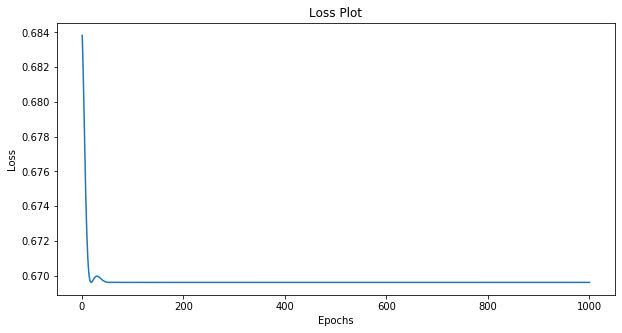

In [58]:
def train(epochs=1000, x_train_tensor=x_train_tensor, y_train_tensor=y_train_tensor):
    torch.cuda.empty_cache()
    loss_list  = []
    for epoch in range(epochs):
        y_hat = model(x_train_tensor)
        loss  = criterion(y_hat, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()
    # Evaluate
    with torch.no_grad():
        model.train('False')
        y_hat = model(x_test_tensor)
        nll   = criterion(y_hat.squeeze(), y_test_tensor)
        y_hat = y_hat.argmax(axis=1)
        print("Accuracy Score:", accuracy_score(y_hat, y_test))

    print("Negative Log Likelihood (NLL):", nll.item())
    
    plt.figure(figsize=(10,5))
    plt.title("Loss Plot")
    plt.plot(np.arange(1,epochs+1), loss_list)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    

train(epochs=epochs)



In [ ]:
Test Different Graphs

In [97]:
class Net(nn.Module):
    layers = None
    def __init__(self,N,M):
        super(Net, self).__init__()
        self.first  = nn.Linear(13,M)
        self.layers = N
        self.hidden = nn.Linear(M,M)
        self.last   = nn.Linear(M,2)
    def forward(self,x):
        #x = x.view(-1, 13)
        x = torch.sigmoid(self.first(x))
        for i in range(self.layers):
            x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.last(x))
        return x


def train(N,M=16,epochs=10, x_train_tensor=x_train_tensor, y_train_tensor=y_train_tensor):
    # Declare Model
    model = Net(N,M)
    # Declare Optimizers
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs, eta_min=0.00001, last_epoch=-1)
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_hat = model(x_train_tensor)
        loss  = criterion(y_hat, y_train_tensor)
        loss.backward()
        optimizer.step()
    # Evaluate
    with torch.no_grad():
        model.train('False')
        y_hat = model(x_test_tensor)
        nll   = criterion(y_hat.squeeze(), y_test_tensor)
        y_hat = y_hat.argmax(axis=1)
        return accuracy_score(y_hat, y_test)

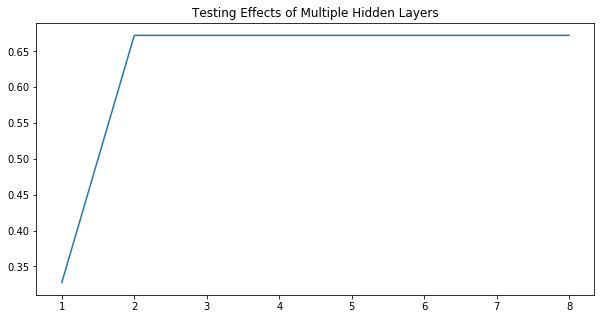

In [99]:
N = [1, 2, 3, 4, 5, 6, 7, 8]
M = [2, 4, 8, 16, 32, 64, 128, 256]
Accuracy_List = []
for i in range(len(N)):
    accuracy = train(N[i], M[i])
    Accuracy_List.append(accuracy)
 
x_range = np.arange(1, (len(N)+1))
plt.figure(figsize=(10,5))
plt.title("Testing Effects of Multiple Hidden Layers")
plt.plot(x_range, Accuracy_List)
plt.show()

#### Problem 4.3
* #### __Important :__  Here, you are not allowed to use the Optim package. 

In [164]:
class FNN(nn.Module):
    def __init__(self,):
        super().__init__()
        
        # Dimensions for input, hidden, and output
        self.input_dim = 13
        self.hidden_dim = 16
        self.output_dim = 1
        
        # Learning Rate Definition 
        self.learning_rate = 0.001
        
        # Weights 1
        self.w1 = torch.randn(self.input_dim, self.hidden_dim)
        
        # Weights 2
        self.w2 = torch.randn(self.hidden_dim, self.output_dim)
        
    def sigmoid(self, s):
        ''' Sigmoid Function '''
        return 1 / (1 + torch.exp(-s))
    
    def sigmoid_first_order_derivative(self, s):
        ''' Sigmoid First Order Derivative'''
        return s * (1 - s)
    
    def forward(self, X):
        ''' Forward Pass '''
        # First Linear Layer
        self.y1 = torch.matmul(X, self.w1)
        # Sigmoid on First Layer
        self.y2 = self.sigmoid(self.y1)
        # Second Linear Layer
        self.y3 = torch.matmul(self.y2, self.w2)
        # Sigmoid on Last Layer
        y4 = self.sigmoid(self.y3)
        return y4
    
    def backward(self, X, l, y4):
        # Derivative of binary cross entropy cost w.r.t. final output y4
        self.dC_dy4 = y4 - l
        
        self.dy4_dy3 = self.sigmoid_first_order_derivative(y4)
        self.dy3_dw2 = self.y2
        
        # Y4 delta: dC_dy4 dy4_dy3
        self.y4_delta = self.dC_dy4 * self.dy4_dy3
        
        # This is our gradients for w1: dC_dy4 dy4_dy3 dy3_dw2
        self.dC_dw2 = torch.matmul(torch.t(self.dy3_dw2), self.y4_delta)
        
        self.dy3_dy2 = self.w2
        self.dy2_dy1 = self.sigmoid_first_order_derivative(self.y2)
        
        # Y2 delta: (dC_dy4 dy4_dy3) dy3_dy2 dy2_dy1
        self.y2_delta = torch.matmul(self.y4_delta, torch.t(self.dy3_dy2)) * self.dy2_dy1
        
        # Gradients for w1: (dC_dy4 dy4_dy3) dy3_dy2 dy2_dy1 dy1_dw1
        self.dC_dw1 = torch.matmul(torch.t(X), self.y2_delta)
        
        # Gradient descent on the weights from our 2 linear layers
        self.w1 -= self.learning_rate * self.dC_dw1
        self.w2 -= self.learning_rate * self.dC_dw2
        
    def train(self, X, l):
        # Forward Propagation
        y4 = self.forward(X)
        
        # Backward Propagation and gradient descent
        self.backward(X,l,y4)
    
    def cross_entropy_loss(self, y, y_hat):
        return -(y * torch.log(y_hat) + (1-y) * torch.log(1 - y_hat))


[0.7003746628761292, 0.6915897130966187, 0.6849930882453918, 0.6801803708076477, 0.676767110824585]


Text(0.5, 1.0, 'Loss Function')

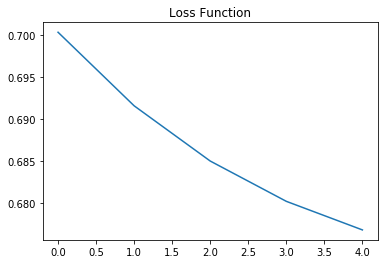

In [166]:
model = FNN()

# Loss Lists
num_epochs = 5
loss_list = []
mean_loss = None
y_hat = None
y_train_tensor2 = y_train_tensor.reshape(-1,1)
# Train Model for 100 Epochs
for epoch in range(num_epochs):
    # Forward Pass
    y_hat = model(x_train_tensor)
    # Calculate loss
    loss = model.cross_entropy_loss(y_train_tensor, y_hat)
    mean_loss = torch.mean(loss).detach().item()
    loss_list.append(mean_loss)
    
    # Backward propagation
    model.train(x_train_tensor,  y_train_tensor2)
    

print(loss_list)

# Plot Loss
pd.Series(loss_list).plot()
plt.title("Loss Function")

#### Hidden Layers

In [25]:
### Dataset Has Been Normalized
scaler1 = StandardScaler()
scaler2 = StandardScaler()

x_train_std = scaler1.fit_transform(X_train)
x_test_std = scaler2.fit_transform(X_test)

x_train_tensor = torch.tensor(X_train.values.astype('float32'))
x_test_tensor  = torch.tensor(X_test.values.astype('float32'))

# Train
y_train_tensor = y_train.copy()
y_train_tensor = y_train_tensor.to_numpy()
y_train_tensor = torch.tensor(y_train_tensor)

# Test
y_test_tensor = y_test.copy()
y_test_tensor = y_test_tensor.to_numpy()
y_test_tensor = torch.tensor(y_test_tensor)

print("X_Test Shape: ", x_train_tensor.shape)
print("Y_test Shape: ", y_train_tensor.shape)

X_Test Shape:  torch.Size([398, 13])
Y_test Shape:  torch.Size([398])


In [195]:
class Net(nn.Module):
    def __init__(self,N,M):
        super(Net, self).__init__()
        
        # Creating Weights
        self.W1 = torch.randn(13, M)
        self.W2 = torch.randn(M, M)
        self.W3 = torch.randn(M, M)
        self.W4 = torch.randn(M,2)
        print("W4 Shape: ", self.W4.shape)
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    def forward(self,X):
        self.z1 = torch.matmul(X, self.W1)          # Input to First Layer
        self.z2 = torch.sigmoid(self.z1)            # Activation Function
        self.z3 = torch.matmul(self.z2, self.W2)    # First Hidden Layer
        self.z4 = torch.sigmoid(self.z3)            # Activation Function
        self.z5 = torch.matmul(self.z4, self.W3)    # Second Hidden Layer
        self.z6 = torch.sigmoid(self.z5)            # Activation Function
        self.z7 = torch.matmul(self.z6, self.W4)    # Last Layer
        self.z8 = torch.sigmoid(self.z7)            # Return
        return self.z8
    def backward(self, X, y, o, loss):
        learning_rate = 0.01
        self.o_error  = y - o 
        self.delta1   = self.o_error * self.sigmoid_derivative(o)
        self.z2_error = torch.matmul(self.delta1, torch.t(self.W4))
        self.delta2   = self.z2_error * self.sigmoid_derivative(self.z6)
        self.z3_error = torch.matmul(self.delta2, torch.t(self.W3))
        self.delta3   = self.z3_error * self.sigmoid_derivative(self.z4) 
        self.z4_error = torch.matmul(self.delta3, torch.t(self.W2))
        self.delta4   = self.z4_error * self.sigmoid_derivative(self.z2)
        
        self.W4 += learning_rate*torch.matmul(torch.t(self.z6), self.delta1)
        self.W3 += learning_rate*torch.matmul(torch.t(self.z4), self.delta2)
        self.W2 += learning_rate*torch.matmul(torch.t(self.z3), self.delta3)
        self.W1 += learning_rate*torch.matmul(torch.t(X), self.delta4)
        

        
    def cross_entropy_loss(self, y, y_hat):
        return -(y * torch.log(y_hat) + (1-y) * torch.log(1 - y_hat))

model = Net(2,16)
model

W4 Shape:  torch.Size([16, 2])


Net()

Text(0.5, 1.0, 'Loss Function')

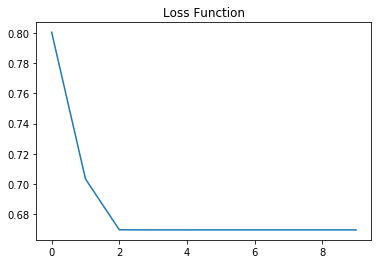

In [196]:
# Loss Lists
num_epochs = 10
loss_list = []
y_hat = None
y_train_tensor2 = y_train_tensor.reshape(-1,1)
# Train Model for 100 Epochs
for epoch in range(num_epochs):
    # Forward Pass
    y_hat = model.forward(x_train_tensor)
    # Calculate loss
    loss = model.cross_entropy_loss(y_train_tensor2, y_hat)
    #print(loss)
    mean_loss = torch.mean(loss).detach().item()
    loss_list.append(mean_loss)
   
    model.backward(x_train_tensor, y_train_tensor2, y_hat, loss)
    
    # Backward propagation
    
# Plot Loss
pd.Series(loss_list).plot()
plt.title("Loss Function")

In [ ]:
# Calculate Accuracy


### Problem 5: First order optimization methods

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils import data
import torch.nn as nn

# Transforms
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,) )
        ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

# Download and prepare the MNIST data set 
train_dataset = dsets.MNIST(root='../data', train=True, transform=train_transform, download=True)
test_dataset = dsets.MNIST(root='../data',  train=False, transform=test_transform)

"""
The data features can be extracted as train_dataset/test_dataset.data
The labels can be extracted as train_dataset/test_dataset.targets 
Note that the data are 28x28 images which you will have to transform to vectors.  
"""

batch_size = 256

train_iter = data.DataLoader(train_dataset, batch_size, shuffle=True,  num_workers=4)
test_iter  = data.DataLoader(test_dataset,  batch_size, shuffle=False, num_workers=4)


#### Consise Implementation 

In [24]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 784)
    
net = nn.Sequential(Reshape(), nn.Linear(784,10)).cuda()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)


epochs = 3
for epoch in range(epochs):
    if epoch == 0:
        print("Clearing Cuda Cache")
        torch.cuda.empty_cache()
    # Train
    net.train()
    for batch_idx, (data, target) in enumerate(train_iter):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = net(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_iter.dataset),
                100. * batch_idx / len(train_iter), l.item()))
            
    # Test 
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_iter:
            data, target = data.cuda(), target.cuda()
            output = net(data)
            test_loss += loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
    test_loss /- len(test_iter.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_iter.dataset),
        100. * correct / len(test_iter.dataset)))

Clearing Cuda Cache
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.548841
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.337611
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.305005

Test set: Average loss: 12.7904, Accuracy: 9097/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.259498
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.323872
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.226495

Test set: Average loss: 11.6499, Accuracy: 9165/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.339402
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.254757
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.341882

Test set: Average loss: 11.9672, Accuracy: 9117/10000 (91%)



#### Momentum

In [11]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 784)
        out = self.linear(x)
        return out

def momentum(model, train_loader, criterion, learning_rate, epoch, Lamb):
    # Momentum
    update = 0
    train_loss = 0
    mu = 0.9
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # optimizer zero grad
        output = model(data)
        loss = criterion(output, target) + Lamb*torch.norm(model.linear.weight)
        loss.backward()
        # calculate momentum updates
        with torch.no_grad():
            gradients = model.linear.weight.grad
            weights = model.linear.weight
            update = mu * update + gradients

            # update parameters
            model.linear.weight = torch.nn.Parameter(weights - learning_rate * update)
            train_loss += loss.item()
    return train_loss/ len(train_loader.dataset)


def test(model,loss, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += loss(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        correct = 100. * correct / len(test_loader.dataset)
        return test_loss, correct

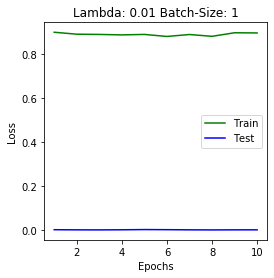

Momentum for Lambda:0.01 Batch-Size:1 Accuracy = 87.99


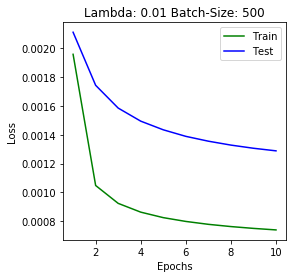

Momentum for Lambda:0.01 Batch-Size:500 Accuracy = 90.83


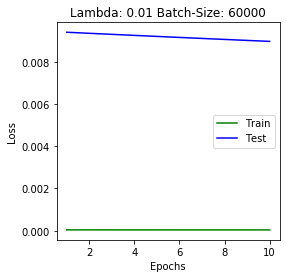

Momentum for Lambda:0.01 Batch-Size:60000 Accuracy = 16.87


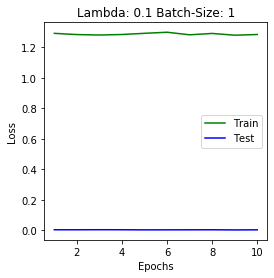

Momentum for Lambda:0.1 Batch-Size:1 Accuracy = 85.04


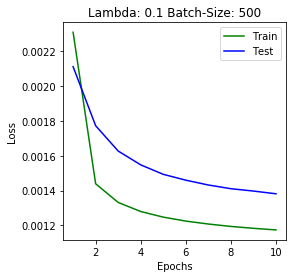

Momentum for Lambda:0.1 Batch-Size:500 Accuracy = 90.81


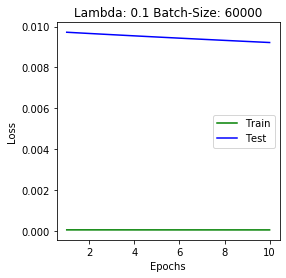

Momentum for Lambda:0.1 Batch-Size:60000 Accuracy = 15.33


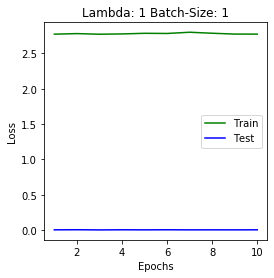

Momentum for Lambda:1 Batch-Size:1 Accuracy = 64.66


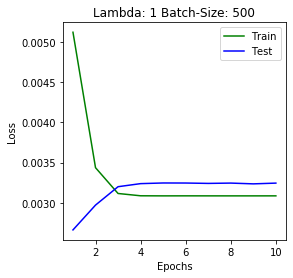

Momentum for Lambda:1 Batch-Size:500 Accuracy = 86.57


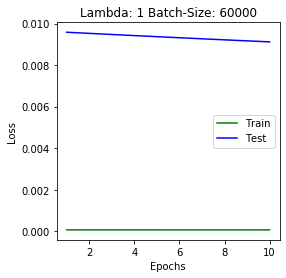

Momentum for Lambda:1 Batch-Size:60000 Accuracy = 17.97


In [14]:
loss = nn.CrossEntropyLoss()

Lambda_list = [0.01, 0.1, 1]
Batch_Size  = [1, 500, 6e4]

for i in Lambda_list:
    for batch_num in Batch_Size:
        batch_num = int(batch_num)
        
        # Clear Data Torch Cache
        torch.cuda.empty_cache()
        
        # Create Model 
        model = LogisticRegressionModel(784,10).cuda()
        
        # Create Dataset
        train_iter = None
        train_iter = data.DataLoader(train_dataset, batch_num, shuffle=True,  num_workers=2, pin_memory=True)
        
        train_loss_list = []
        test_loss_list  = []
        # Send To Train Loop
        for epoch in range(10):
            train_loss = momentum(model, train_iter, loss, learning_rate=0.001, epoch=epoch, Lamb=i)
            test_loss = test(model, loss, test_iter)[0]
            
            # Append Results
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            
        # Plot 
        plt.figure(figsize=(4,4))
        x_range = np.arange(1,(len(train_loss_list) + 1))
        plt.plot(x_range, train_loss_list, 'green', label="Train")
        plt.plot(x_range, test_loss_list, 'blue', label="Test")
        plt.title("Lambda: " + str(i) + " Batch-Size: " + str(batch_num))
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()
            
        # Calclulate Accuracy
        test_accuracy = test(model, loss, test_iter)[1]
        print("Momentum for Lambda:" + str(i) + " Batch-Size:" + str(batch_num) + " Accuracy = " + str(test_accuracy))

#### Nesterov

In [15]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 784)
        out = self.linear(x)
        return out

def Nesterov(model, train_loader, criterion, learning_rate, epoch, Lamb):
    train_loss = 0
    model.train()
    
    Beta = 0.95
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # optimizer zero grad
        output = model(data)
        loss = criterion(output, target) + Lamb*torch.norm(model.linear.weight)
        loss.backward()
        # calculate momentum updates
        with torch.no_grad():
            gradients = model.linear.weight.grad
            weights = model.linear.weight
            
            tk = weights - (1/Beta) * gradients
            lambda_0 = torch.zeros(1)
            lambda_k = (1 + (torch.sqrt(1 + 4*lambda_0**2)))/2
            gamma_k  = (1 - lambda_0)/(lambda_k)
            lambda_0 = lambda_k
            
            if batch_idx == 0:
                w = (1 - gamma_k.cuda()) * tk.cuda() 
            else:
                w = (1 - gamma_k.cuda()) * tk + gamma_k.cuda() * previousTK.cuda()
            previousTK = tk

            # update parameters
            model.linear.weight = torch.nn.Parameter(w)
            train_loss += loss.item()
    return train_loss/ len(train_loader.dataset)


def test(model,loss, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += loss(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        correct = 100. * correct / len(test_loader.dataset)
        return test_loss, correct

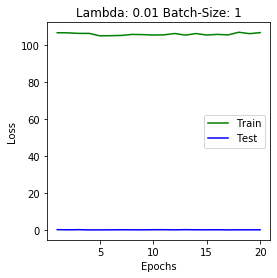

Momentum for Lambda:0.01 Batch-Size:1 Accuracy = 86.61


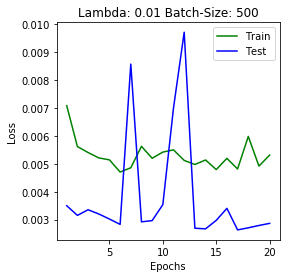

Momentum for Lambda:0.01 Batch-Size:500 Accuracy = 91.27


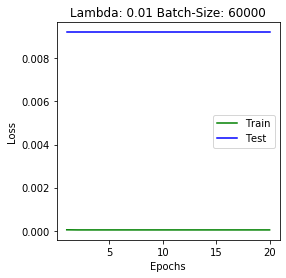

Momentum for Lambda:0.01 Batch-Size:60000 Accuracy = 11.35


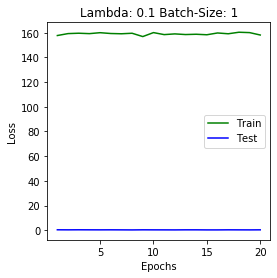

Momentum for Lambda:0.1 Batch-Size:1 Accuracy = 80.33


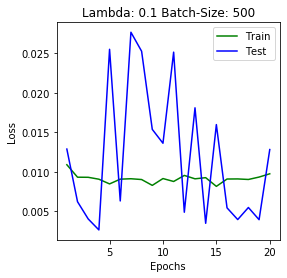

Momentum for Lambda:0.1 Batch-Size:500 Accuracy = 71.87


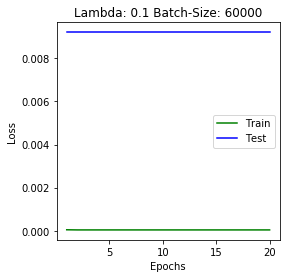

Momentum for Lambda:0.1 Batch-Size:60000 Accuracy = 9.74


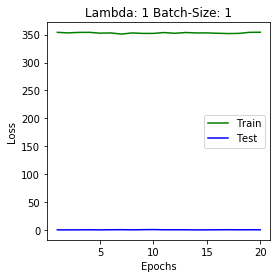

Momentum for Lambda:1 Batch-Size:1 Accuracy = 58.16


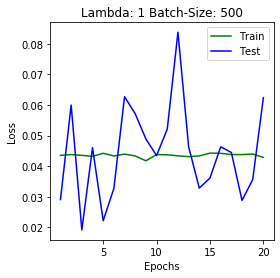

Momentum for Lambda:1 Batch-Size:500 Accuracy = 45.37


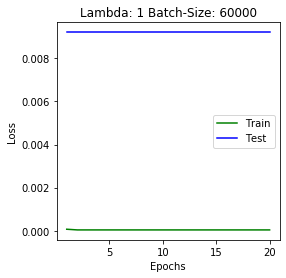

Momentum for Lambda:1 Batch-Size:60000 Accuracy = 10.32


In [17]:
loss = nn.CrossEntropyLoss()

Lambda_list = [0.01, 0.1, 1]
Batch_Size  = [1, 500, 6e4]

for i in Lambda_list:
    for batch_num in Batch_Size:
        batch_num = int(batch_num)
        
        # Clear Data Torch Cache
        torch.cuda.empty_cache()
        
        # Create Model 
        model = LogisticRegressionModel(784,10).cuda()
        
        # Create Dataset
        train_iter = None
        train_iter = data.DataLoader(train_dataset, batch_num, shuffle=True,  num_workers=2, pin_memory=True)
        
        train_loss_list = []
        test_loss_list  = []
        # Send To Train Loop
        for epoch in range(20):
            train_loss = Nesterov(model, train_iter, loss, learning_rate=0.001, epoch=epoch, Lamb=i)
            test_loss = test(model, loss, test_iter)[0]
            
            # Append Results
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            
        # Plot 
        plt.figure(figsize=(4,4))
        x_range = np.arange(1,(len(train_loss_list) + 1))
        plt.plot(x_range, train_loss_list, 'green', label="Train")
        plt.plot(x_range, test_loss_list, 'blue', label="Test")
        plt.title("Lambda: " + str(i) + " Batch-Size: " + str(batch_num))
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()
            
        # Calclulate Accuracy
        test_accuracy = test(model, loss, test_iter)[1]
        print("Momentum for Lambda:" + str(i) + " Batch-Size:" + str(batch_num) + " Accuracy = " + str(test_accuracy))

#### RMSProp

In [18]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 784)
        out = self.linear(x)
        return out

def RMSprop(model, train_loader, criterion, learning_rate, epoch, Lamb):
    train_loss = 0
    model.train()
    
    Beta = 0.9
    Gamma = 1
    epsilon = 1e-8
    v = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # optimizer zero grad
        output = model(data)
        loss = criterion(output, target) + Lamb*torch.norm(model.linear.weight)
        loss.backward()
        # calculate momentum updates
        with torch.no_grad():
            gradients = model.linear.weight.grad
            weights = model.linear.weight
            v = (1 - Beta)*v + Beta*gradients*gradients
            b = Gamma /(epsilon + torch.sqrt(v))
            w = weights - learning_rate*b * gradients
            # update parameters
            model.linear.weight = torch.nn.Parameter(w)
            train_loss += loss.item()
    return train_loss/ len(train_loader.dataset)


def test(model,loss, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += loss(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        correct = 100. * correct / len(test_loader.dataset)
        return test_loss, correct

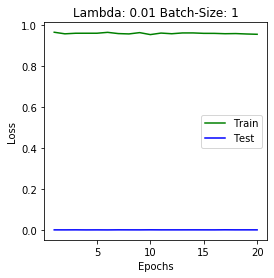

Momentum for Lambda:0.01 Batch-Size:1 Accuracy = 84.68


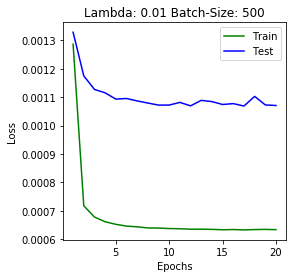

Momentum for Lambda:0.01 Batch-Size:500 Accuracy = 92.34


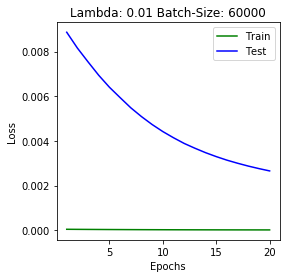

Momentum for Lambda:0.01 Batch-Size:60000 Accuracy = 84.54


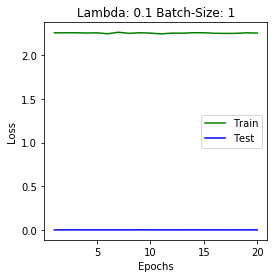

Momentum for Lambda:0.1 Batch-Size:1 Accuracy = 79.25


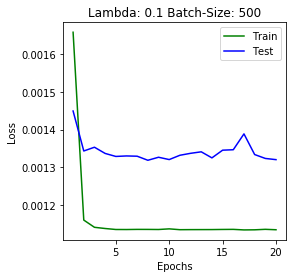

Momentum for Lambda:0.1 Batch-Size:500 Accuracy = 91.27


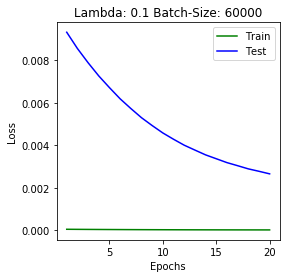

Momentum for Lambda:0.1 Batch-Size:60000 Accuracy = 84.94


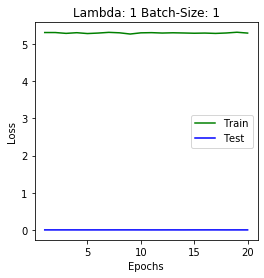

Momentum for Lambda:1 Batch-Size:1 Accuracy = 74.61


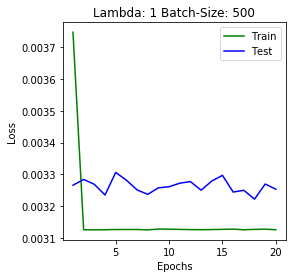

Momentum for Lambda:1 Batch-Size:500 Accuracy = 85.11


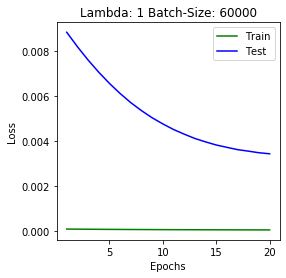

Momentum for Lambda:1 Batch-Size:60000 Accuracy = 83.2


In [19]:
loss = nn.CrossEntropyLoss()

Lambda_list = [0.01, 0.1, 1]
Batch_Size  = [1, 500, 6e4]

for i in Lambda_list:
    for batch_num in Batch_Size:
        batch_num = int(batch_num)
        
        # Clear Data Torch Cache
        torch.cuda.empty_cache()
        
        # Create Model 
        model = LogisticRegressionModel(784,10).cuda()
        
        # Create Dataset
        train_iter = None
        train_iter = data.DataLoader(train_dataset, batch_num, shuffle=True,  num_workers=2, pin_memory=True)
        
        train_loss_list = []
        test_loss_list  = []
        # Send To Train Loop
        for epoch in range(20):
            train_loss = RMSprop(model, train_iter, loss, learning_rate=0.001, epoch=epoch, Lamb=i)
            test_loss = test(model, loss, test_iter)[0]
            
            # Append Results
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            
        # Plot 
        plt.figure(figsize=(4,4))
        x_range = np.arange(1,(len(train_loss_list) + 1))
        plt.plot(x_range, train_loss_list, 'green', label="Train")
        plt.plot(x_range, test_loss_list, 'blue', label="Test")
        plt.title("Lambda: " + str(i) + " Batch-Size: " + str(batch_num))
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()
            
        # Calclulate Accuracy
        test_accuracy = test(model, loss, test_iter)[1]
        print("Momentum for Lambda:" + str(i) + " Batch-Size:" + str(batch_num) + " Accuracy = " + str(test_accuracy))

#### Adam

In [20]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 784)
        out = self.linear(x)
        return out

def ADM(model, train_loader, criterion, learning_rate, epoch, Lamb):
    train_loss = 0
    model.train()
    
    m0_1 = 0
    m0_2 = 0
    Beta1 = .9
    Beta2 = .999
    epsilon = 1e-8
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # optimizer zero grad
        output = model(data)
        loss = criterion(output, target) + Lamb*torch.norm(model.linear.weight)
        loss.backward()
        # calculate momentum updates
        with torch.no_grad():
            gradients = model.linear.weight.grad
            weights = model.linear.weight
            m0_1 = Beta1 * m0_1 + (1 - Beta1)*gradients
            debias_m0_1 = m0_1 * (1 - Beta1**(batch_idx+1))**-1
            m0_2 = Beta2 *m0_2 + (1 - Beta2)*gradients * gradients
            debias_m0_2 = m0_2 * (1 - Beta2**(batch_idx+1))**-1
            
            w = weights - learning_rate*debias_m0_1 / (epsilon + torch.sqrt(debias_m0_2))
            
            # update parameters
            model.linear.weight = torch.nn.Parameter(w)
            train_loss += loss.item()
    return train_loss/ len(train_loader.dataset)


def test(model,loss, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += loss(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        correct = 100. * correct / len(test_loader.dataset)
        return test_loss, correct

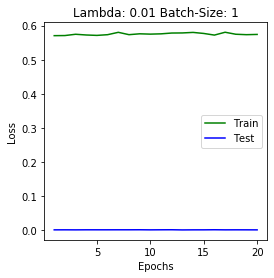

Momentum for Lambda:0.01 Batch-Size:1 Accuracy = 89.93


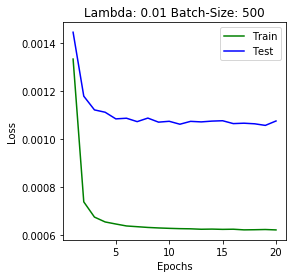

Momentum for Lambda:0.01 Batch-Size:500 Accuracy = 92.02


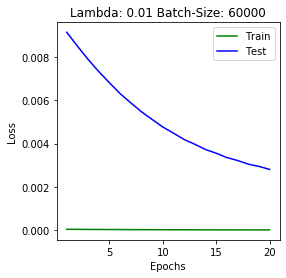

Momentum for Lambda:0.01 Batch-Size:60000 Accuracy = 83.39


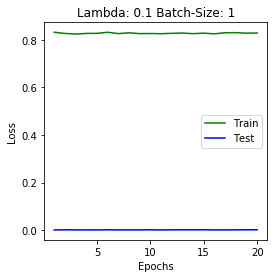

Momentum for Lambda:0.1 Batch-Size:1 Accuracy = 82.52


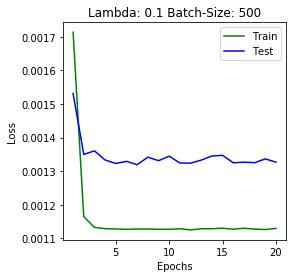

Momentum for Lambda:0.1 Batch-Size:500 Accuracy = 91.33


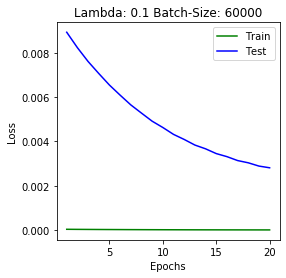

Momentum for Lambda:0.1 Batch-Size:60000 Accuracy = 83.03


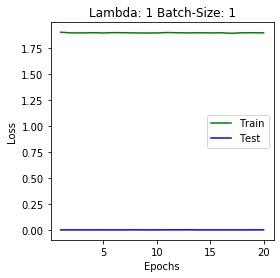

Momentum for Lambda:1 Batch-Size:1 Accuracy = 72.04


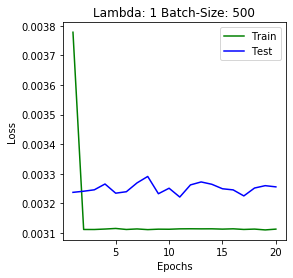

Momentum for Lambda:1 Batch-Size:500 Accuracy = 85.98


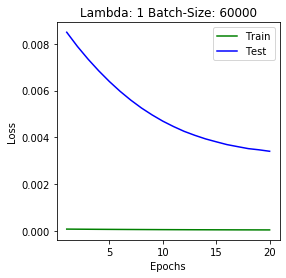

Momentum for Lambda:1 Batch-Size:60000 Accuracy = 84.0


In [21]:
loss = nn.CrossEntropyLoss()

Lambda_list = [0.01, 0.1, 1]
Batch_Size  = [1, 500, 6e4]

for i in Lambda_list:
    for batch_num in Batch_Size:
        batch_num = int(batch_num)
        
        # Clear Data Torch Cache
        torch.cuda.empty_cache()
        
        # Create Model 
        model = LogisticRegressionModel(784,10).cuda()
        
        # Create Dataset
        train_iter = None
        train_iter = data.DataLoader(train_dataset, batch_num, shuffle=True,  num_workers=2, pin_memory=True)
        
        train_loss_list = []
        test_loss_list  = []
        # Send To Train Loop
        for epoch in range(20):
            train_loss = ADM(model, train_iter, loss, learning_rate=0.001, epoch=epoch, Lamb=i)
            test_loss = test(model, loss, test_iter)[0]
            
            # Append Results
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            
        # Plot 
        plt.figure(figsize=(4,4))
        x_range = np.arange(1,(len(train_loss_list) + 1))
        plt.plot(x_range, train_loss_list, 'green', label="Train")
        plt.plot(x_range, test_loss_list, 'blue', label="Test")
        plt.title("Lambda: " + str(i) + " Batch-Size: " + str(batch_num))
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()
            
        # Calclulate Accuracy
        test_accuracy = test(model, loss, test_iter)[1]
        print("Momentum for Lambda:" + str(i) + " Batch-Size:" + str(batch_num) + " Accuracy = " + str(test_accuracy))